In [49]:
# ipython
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
sns.set_style("white")
import glob
import json
import os
import sys
import shutil

def save_fig(ax, title=None, pdfname="plot.pdf"):
    if title:
        ax.set_title(title)
    ax.get_figure().savefig(pdfname, bbox_inches="tight")   

In [10]:
def read_json(x):
    with open(x) as xfp:
        return json.load(xfp)

def clean_up(users, images):

    dd = images.groupby(by="uuid").apply(lambda x: all(x["rating"] == 1) or len(x) <50).reset_index()
    # filter out participants who rated all = 1, or who rated less than 50 images
    #dx = images.groupby(by="uuid").apply(lambda x: len(x)).reset_index()
    #d(dx)
    dd = dd.rename(columns={0: "excluded"})

    dimages = pd.merge(images, dd, left_on="uuid", right_on="uuid")
    dimages = dimages[dimages["excluded"] != True]
    dusers = pd.merge(dd, users, left_on="uuid", right_on="uuid")
    old = len(dusers)
    dusers = dusers[dusers["excluded"] != True]

    print(f"excluded users: {old - len(dusers)}")
    return dusers, dimages


import scipy.stats as st

def calculate_stats(images):
    def confidence(x):
        x = x["rating"]
        # estimate the confidence interval # To be checked
        y = st.t.interval(0.95, len(x) - 1, loc=np.mean(x), scale=st.sem(x))
        return  (y[1] - y[0]) / 2

    def rating_dist(x):
        #print(x)
        res = {
            "num_ratings": 0
        }
        hist = {}

        for rating in x["rating"].values:
            hist[rating] = hist.get(rating, 0) + 1
            res["num_ratings"] += 1
        for r in range(1,6):
            res[f"count_{r}"] = hist.get(r, 0)
        return pd.Series(res)

    mos = images[["filename", "rating"]].groupby(by="filename").mean().reset_index().rename(columns={"rating": "mos"})
    ci = images[["filename", "rating"]].groupby(by="filename").apply(confidence).reset_index().rename(columns={0: "ci"})
    std = images[["filename", "rating"]].groupby(by="filename").std().reset_index().rename(columns={"rating": "std"})
    
    dist = images[["filename", "rating"]].groupby(by="filename").apply(rating_dist).reset_index() #.rename(columns={0: "ci"})

    stats = pd.merge(std, pd.merge(pd.merge(ci, mos), dist))
    return stats


def make_plots(basedir, testname):
    users = pd.DataFrame(read_json(sorted(list(glob.glob(basedir + "/*_users.json")))[-1]))
    images = pd.DataFrame(read_json(sorted(list(glob.glob(basedir + "/*_images.json")))[-1]))
    
    users, images = clean_up(users, images)
    d(images.head())
    d(users.head())
    sns.set(rc={'figure.figsize':(6,3)})
    sns.set_style("white")
    num_users = len(users)
    num_ratings = len(images)
    ax = sns.boxplot(images.groupby(by="filename").count().reset_index()["_id"])
    save_fig(ax, f"test #1: {testname}: ratins per image; users={num_users}; ratings={num_ratings}", f"ratings_per_image_{testname}.pdf")
    plt.show()
    
    ax = sns.countplot(images["rating"])
    save_fig(ax, f"test #1: {testname}: counts per rating; users={num_users}; ratings={num_ratings}", f"counts_per_rating_{testname}.pdf")
    plt.show()
    
    di = images.groupby(by="filename").mean().reset_index()[["filename", "rating"]]
    ax = sns.distplot(di["rating"])

    save_fig(ax, f"test #1: {testname}: mean rating dist; users={num_users}; ratings={num_ratings}", f"mean_rating_dist_{testname}.pdf")

    return calculate_stats(images)


excluded users: 31


,_id,filename,uuid,rating,date,__v,excluded
0,{'$oid': '6092740eb3c269004234ce1c'},static/images/own/medium/IMG_5792.jpg,a1e5dbcb-0c19-4ab7-b0f0-b253efe6c7d9,2,{'$date': '2021-05-05T10:31:42.15Z'},0,False
1,{'$oid': '60927412b3c269004234ce1d'},static/images/aadb/medium/farm1_298_2019361299...,a1e5dbcb-0c19-4ab7-b0f0-b253efe6c7d9,1,{'$date': '2021-05-05T10:31:46.134Z'},0,False
2,{'$oid': '60927415b3c269004234ce1e'},static/images/koniq10k/medium/3726632967.jpg,a1e5dbcb-0c19-4ab7-b0f0-b253efe6c7d9,1,{'$date': '2021-05-05T10:31:49.516Z'},0,False
3,{'$oid': '6092741ab3c269004234ce1f'},static/images/500px_cc0/medium/179537679_coffe...,a1e5dbcb-0c19-4ab7-b0f0-b253efe6c7d9,3,{'$date': '2021-05-05T10:31:54.115Z'},0,False
4,{'$oid': '6092741eb3c269004234ce20'},static/images/500px_cc0/medium/1011015217_Anem...,a1e5dbcb-0c19-4ab7-b0f0-b253efe6c7d9,1,{'$date': '2021-05-05T10:31:58.709Z'},0,False


,uuid,excluded,_id,image_list,image_index,date,__v,age_range,browser_agent,computer_type,eye_quality,room_quality,screen_size
0,024ec8d5-97c8-473e-b656-8ff18674fce7,False,{'$oid': '60d9664b8f91c80031d76d0d'},"[static/images/ava/medium/311199.jpg, static/i...",200,{'$date': '2021-06-28T06:03:55.121Z'},0,30 to 39,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:8...,Desktop,Good(4),Alone in a Quiet Room,1920x899
1,03b79355-3a79-4563-aa4c-d032a87d8ad5,False,{'$oid': '609a91e79a5d0407780e0618'},[static/images/aadb/medium/farm1_302_200083076...,200,{'$date': '2021-05-11T14:17:11.985Z'},0,18 to 24,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:8...,Desktop,Excellent(5),Alone in a Quiet Room,1920x938
2,03bb3a87-9d27-433d-8321-045bb7cc5070,False,{'$oid': '60d8abaa87f3f100265b9e49'},"[static/images/koniq10k/medium/8164688693.jpg,...",200,{'$date': '2021-06-27T16:47:38.8Z'},0,25 to 29,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:8...,Laptop,Good(4),Some Noise and Distractions,1920x927
3,057562fe-9b67-4e63-b2c4-d461826ab57e,False,{'$oid': '60d9a0348f91c80031d7701d'},[static/images/500px_cc0/medium/205689063_plea...,200,{'$date': '2021-06-28T10:11:00.486Z'},0,25 to 29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Laptop,Good(4),Alone in a Quiet Room,1920x969
4,0599ab47-3663-41a5-a67e-587b64183989,False,{'$oid': '6092ad7b0874cb0084eecfe2'},"[static/images/koniq10k/medium/4819847439.jpg,...",200,{'$date': '2021-05-05T14:36:43.362Z'},0,25 to 29,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,Laptop,Good(4),Alone in a Quiet Room,1280x619


/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


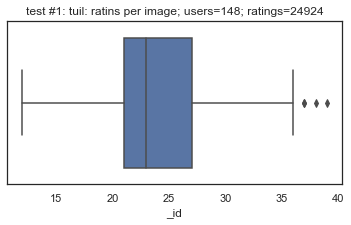

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


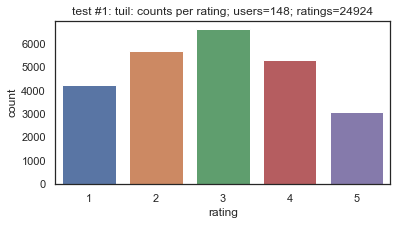

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,0.832971,0.351733,2.208333,24,3,16,2,3,0
1,static/images/500px_cc0/medium/1003502191_Flat...,1.325393,0.547095,3.440000,25,3,2,8,5,7
2,static/images/500px_cc0/medium/1011015162_Anem...,1.268143,0.611225,2.947368,19,2,6,5,3,3
3,static/images/500px_cc0/medium/1011015165_Anem...,0.746101,0.307975,1.840000,25,9,11,5,0,0
4,static/images/500px_cc0/medium/1011015217_Anem...,1.288786,0.509827,2.259259,27,10,7,5,3,2
...,...,...,...,...,...,...,...,...,...,...
1052,static/images/pixabay_first50k/medium/woman-35...,1.416221,0.502170,3.454545,33,5,3,7,8,10
1053,static/images/pixabay_first50k/medium/woman-38...,1.365479,0.519400,2.310345,29,12,6,2,8,1
1054,static/images/pixabay_first50k/medium/woman-53...,1.046788,0.377407,2.468750,32,7,9,10,6,0
1055,static/images/pixabay_first50k/medium/women-12...,1.227649,0.485642,3.259259,27,2,5,10,4,6


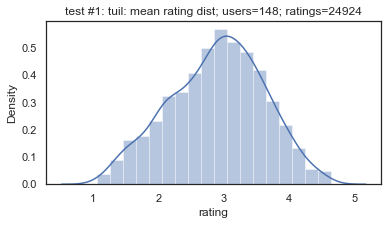

In [11]:
stats_tuil = make_plots("export_aesthetics_tuil", "tuil")

d(stats_tuil)
stats_tuil.to_csv("stats_tuil.csv", index=False)

check for normal distribution
0.9019723635371968 0.0 False


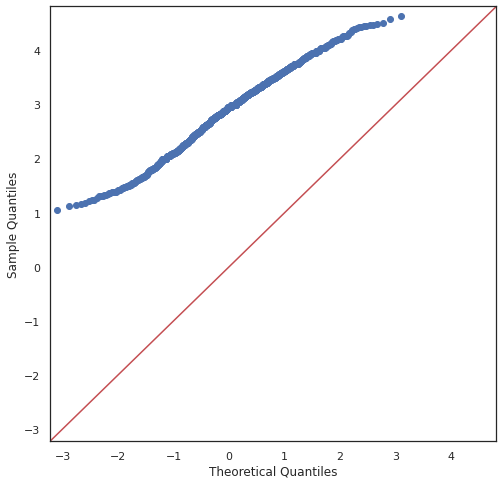

In [34]:
# based on https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
import statsmodels.api as sm
from scipy.stats import norm
import pylab

from scipy.stats import kstest
ks_statistic, p_value = kstest(stats_tuil["mos"], 'norm')

print("check for normal distribution")
print(
    ks_statistic,
    p_value,
    p_value > 0.05
)


sm.qqplot(stats_tuil["mos"], line='45')
pylab.show()

In [35]:
#from statsmodels.stats import shapiro
from statsmodels.stats.diagnostic import lilliefors 
print(
    lilliefors(stats_tuil["mos"], dist="norm")
)

(0.04400601715336783, 0.0009999999999998899)


excluded users: 5


,_id,filename,uuid,rating,date,__v,excluded
0,{'$oid': '60d46c5b4125860010717bb9'},static/images/500px_cc0/medium/139228685_Icy-P...,cdafad4d-c107-478e-aaed-e9c1fee82b30,4,{'$date': '2021-06-24T11:28:27.73Z'},0,False
1,{'$oid': '60d46c614125860010717bba'},static/images/aadb/medium/farm1_357_2009465197...,cdafad4d-c107-478e-aaed-e9c1fee82b30,2,{'$date': '2021-06-24T11:28:33.393Z'},0,False
2,{'$oid': '60d46c644125860010717bbb'},static/images/pixabay_first50k/medium/shellfis...,cdafad4d-c107-478e-aaed-e9c1fee82b30,4,{'$date': '2021-06-24T11:28:36.52Z'},0,False
3,{'$oid': '60d46c684125860010717bbc'},static/images/own/medium/IMG_5127.jpg,cdafad4d-c107-478e-aaed-e9c1fee82b30,1,{'$date': '2021-06-24T11:28:40.574Z'},0,False
4,{'$oid': '60d46c6c4125860010717bbd'},static/images/ava/medium/776337.jpg,cdafad4d-c107-478e-aaed-e9c1fee82b30,1,{'$date': '2021-06-24T11:28:44.434Z'},0,False


,uuid,excluded,_id,image_list,image_index,date,__v,age_range,browser_agent,computer_type,eye_quality,room_quality,screen_size
0,0051a36c-198d-4ad1-9c9a-c3f56871676f,False,{'$oid': '61408ad7e3b7900011029400'},"[static/images/koniq10k/medium/6845847924.jpg,...",200,{'$date': '2021-09-14T11:43:19.381Z'},0,25 to 29,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,Desktop,Excellent(5),Alone in a Quiet Room,1920x937
1,066b0299-2708-4e82-b4ac-31ed25293e3f,False,{'$oid': '61408935e3b7900011028d27'},[static/images/500px_cc0/medium/164175291_pylo...,200,{'$date': '2021-09-14T11:36:21.487Z'},0,30 to 39,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,Laptop,Good(4),Alone in a Quiet Room,1280x590
2,06d0e0a1-f951-4422-91a8-23cf5942c6c0,False,{'$oid': '613f45cde3b79000110278c8'},"[static/images/koniq10k/medium/610496828.jpg, ...",200,{'$date': '2021-09-13T12:36:29.433Z'},0,40 to 49,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,Laptop,Good(4),Alone in a Quiet Room,1536x739
3,06e4621f-dcdd-4b94-bcea-1e96474af807,False,{'$oid': '614089a6e3b7900011028e32'},"[static/images/koniq10k/medium/4819847439.jpg,...",200,{'$date': '2021-09-14T11:38:14.742Z'},0,25 to 29,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Laptop,Good(4),Alone in a Quiet Room,1280x613
4,0b90a20f-9115-4c43-b0fe-3ccf65e0e291,False,{'$oid': '61ae20f367785a0011ace8f9'},"[static/images/koniq10k/medium/331340631.jpg, ...",160,{'$date': '2021-12-06T14:40:51.555Z'},0,50 to 59,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:94....,Desktop,Good(4),Alone in a Quiet Room,1208x912


/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


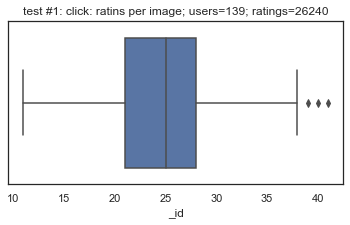

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


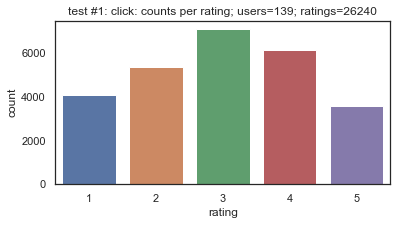

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0
...,...,...,...,...,...,...,...,...,...,...
1053,static/images/pixabay_first50k/medium/woman-35...,1.105013,0.517162,3.800000,20,1,1,5,7,6
1054,static/images/pixabay_first50k/medium/woman-38...,1.228321,0.592032,2.789474,19,3,5,6,3,2
1055,static/images/pixabay_first50k/medium/woman-53...,1.114741,0.573147,2.352941,17,4,6,5,1,1
1056,static/images/pixabay_first50k/medium/women-12...,1.063219,0.448958,3.000000,24,2,5,10,5,2


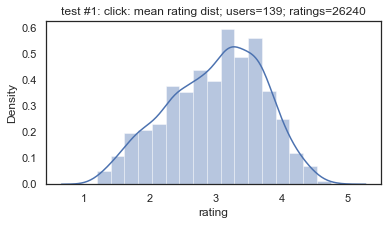

In [12]:
stats_click = make_plots("export_aesthetics_clickworker", "click")

d(stats_click)
stats_click.to_csv("stats_clickworker.csv", index=False)

check for normal distribution


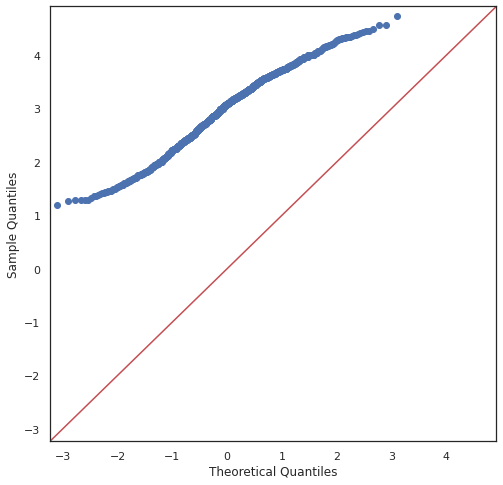

In [36]:
print("check for normal distribution")
sm.qqplot(stats_click["mos"], line='45')


pylab.show()

In [8]:
# compare tuil with clickworker test
d(stats_click)
d(stats_tuil)
dm = pd.merge(stats_click, stats_tuil, left_on="filename", right_on="filename", suffixes=("_click", "_tuil"))

d(dm)

,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0
...,...,...,...,...,...,...,...,...,...,...
1053,static/images/pixabay_first50k/medium/woman-35...,1.105013,0.517162,3.800000,20,1,1,5,7,6
1054,static/images/pixabay_first50k/medium/woman-38...,1.228321,0.592032,2.789474,19,3,5,6,3,2
1055,static/images/pixabay_first50k/medium/woman-53...,1.114741,0.573147,2.352941,17,4,6,5,1,1
1056,static/images/pixabay_first50k/medium/women-12...,1.063219,0.448958,3.000000,24,2,5,10,5,2


,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,0.832971,0.351733,2.208333,24,3,16,2,3,0
1,static/images/500px_cc0/medium/1003502191_Flat...,1.325393,0.547095,3.440000,25,3,2,8,5,7
2,static/images/500px_cc0/medium/1011015162_Anem...,1.268143,0.611225,2.947368,19,2,6,5,3,3
3,static/images/500px_cc0/medium/1011015165_Anem...,0.746101,0.307975,1.840000,25,9,11,5,0,0
4,static/images/500px_cc0/medium/1011015217_Anem...,1.288786,0.509827,2.259259,27,10,7,5,3,2
...,...,...,...,...,...,...,...,...,...,...
1052,static/images/pixabay_first50k/medium/woman-35...,1.416221,0.502170,3.454545,33,5,3,7,8,10
1053,static/images/pixabay_first50k/medium/woman-38...,1.365479,0.519400,2.310345,29,12,6,2,8,1
1054,static/images/pixabay_first50k/medium/woman-53...,1.046788,0.377407,2.468750,32,7,9,10,6,0
1055,static/images/pixabay_first50k/medium/women-12...,1.227649,0.485642,3.259259,27,2,5,10,4,6


,filename,std_click,ci_click,mos_click,num_ratings_click,count_1_click,count_2_click,count_3_click,count_4_click,count_5_click,std_tuil,ci_tuil,mos_tuil,num_ratings_tuil,count_1_tuil,count_2_tuil,count_3_tuil,count_4_tuil,count_5_tuil
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1,0.832971,0.351733,2.208333,24,3,16,2,3,0
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2,1.325393,0.547095,3.440000,25,3,2,8,5,7
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2,1.268143,0.611225,2.947368,19,2,6,5,3,3
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1,0.746101,0.307975,1.840000,25,9,11,5,0,0
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0,1.288786,0.509827,2.259259,27,10,7,5,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,static/images/pixabay_first50k/medium/woman-35...,1.105013,0.517162,3.800000,20,1,1,5,7,6,1.416221,0.502170,3.454545,33,5,3,7,8,10
1053,static/images/pixabay_first50k/medium/woman-38...,1.228321,0.592032,2.789474,19,3,5,6,3,2,1.365479,0.519400,2.310345,29,12,6,2,8,1
1054,static/images/pixabay_first50k/medium/woman-53...,1.114741,0.573147,2.352941,17,4,6,5,1,1,1.046788,0.377407,2.468750,32,7,9,10,6,0
1055,static/images/pixabay_first50k/medium/women-12...,1.063219,0.448958,3.000000,24,2,5,10,5,2,1.227649,0.485642,3.259259,27,2,5,10,4,6


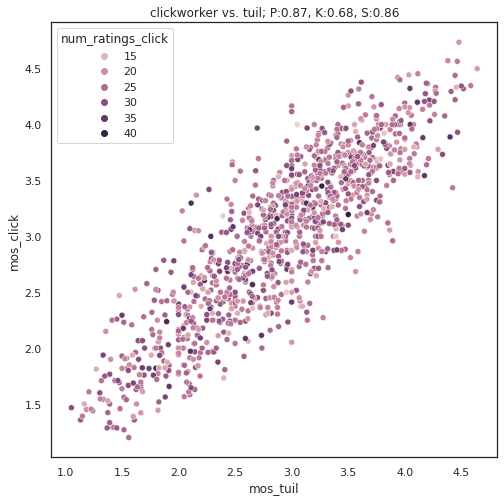

In [9]:

sns.set(rc={'figure.figsize':(8,8)})
sns.set_style("white")
ax = sns.scatterplot(x="mos_tuil", y="mos_click", data=dm, hue="num_ratings_click")

pearson = dm[["mos_tuil", "mos_click"]].corr(method="pearson")["mos_click"].values[0]
kendall = dm[["mos_tuil", "mos_click"]].corr(method="kendall")["mos_click"].values[0]
spearman = dm[["mos_tuil", "mos_click"]].corr(method="spearman")["mos_click"].values[0]

save_fig(
    ax, 
    f"clickworker vs. tuil; P:{pearson.round(2)}, K:{kendall.round(2)}, S:{spearman.round(2)}", 
    f"scatter_click_vs_tuil.pdf"
)


excluded users: 0


,_id,fake,likes,views,filename,uuid,rating,date,__v,excluded
0,{'$oid': '622600ce3b57fd00111a9e04'},0,-1,-1,static/images/pixabay_first50k/medium/fair-540...,38621c73-98c4-4771-bb0a-e065a7aa0157,4,{'$date': '2022-03-07T12:55:42.986Z'},0,False
1,{'$oid': '622600f03b57fd00111a9e09'},0,-1,-1,static/images/500px_cc0/medium/78781399_Nemato...,38621c73-98c4-4771-bb0a-e065a7aa0157,2,{'$date': '2022-03-07T12:56:16.156Z'},0,False
2,{'$oid': '622601013b57fd00111a9e0e'},0,-1,-1,static/images/ava/medium/795726.jpg,38621c73-98c4-4771-bb0a-e065a7aa0157,1,{'$date': '2022-03-07T12:56:33.539Z'},0,False
3,{'$oid': '622601043b57fd00111a9e13'},0,-1,-1,static/images/aadb/medium/farm1_256_2010840835...,38621c73-98c4-4771-bb0a-e065a7aa0157,3,{'$date': '2022-03-07T12:56:36.472Z'},0,False
4,{'$oid': '622601073b57fd00111a9e18'},0,-1,-1,static/images/ava/medium/267110.jpg,38621c73-98c4-4771-bb0a-e065a7aa0157,4,{'$date': '2022-03-07T12:56:39.115Z'},0,False


,uuid,excluded,_id,image_list,fake_likes_list,image_index,query_params,date,__v,age_range,browser_agent,computer_type,eye_quality,room_quality,screen_size
0,0c53b1a9-afdd-4ef9-aae2-1d19de6892a3,False,{'$oid': '622a2eaf1c3fb90011a38ee3'},"[static/images/ava/medium/459853.jpg, static/i...",[],800,,{'$date': '2022-03-10T17:00:31.212Z'},0,18 to 24,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Desktop,Fair(3),Alone in a Quiet Room,1920x1080
1,1f531997-e56b-4e68-afb1-7bd623b35fbd,False,{'$oid': '622a06ff1c3fb90011a35fb8'},"[static/images/ava/medium/824234.jpg, static/i...",[],800,,{'$date': '2022-03-10T14:11:11.323Z'},0,18 to 24,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Desktop,Excellent(5),Alone in a Quiet Room,1920x1080
2,276d268c-9aac-44a9-9974-da06b76e918d,False,{'$oid': '622b48c91c3fb90011a3bded'},"[static/images/koniq10k/medium/4947500856.jpg,...",[],800,,{'$date': '2022-03-11T13:04:09.242Z'},0,18 to 24,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Desktop,Fair(3),Alone in a Quiet Room,1920x1080
3,2a8e20db-3ff6-4944-bcf0-ba31840da3f6,False,{'$oid': '622757291c3fb90011a282fa'},"[static/images/ava/medium/306946.jpg, static/i...",[],800,,{'$date': '2022-03-08T13:16:25.917Z'},0,30 to 39,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Laptop,Good(4),Alone in a Quiet Room,1920x1080
4,2afb5f36-431e-4774-a1cd-ba4cdc16de57,False,{'$oid': '62271bf01c3fb90011a24b57'},"[static/images/koniq10k/medium/8528934790.jpg,...",[],800,,{'$date': '2022-03-08T09:03:44.232Z'},0,25 to 29,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,Desktop,Fair(3),Alone in a Quiet Room,1920x1080


/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


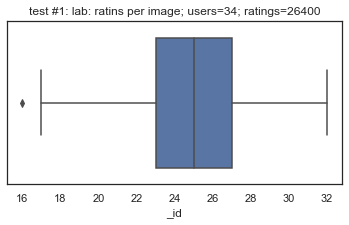

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


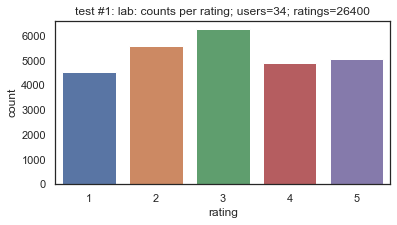

/home/sgoering/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,1.202451,0.533137,3.272727,22,1,6,5,6,4
1,static/images/500px_cc0/medium/1003502191_Flat...,1.295401,0.512443,3.296296,27,4,2,8,8,5
2,static/images/500px_cc0/medium/1011015162_Anem...,1.236033,0.479284,2.750000,28,4,9,9,2,4
3,static/images/500px_cc0/medium/1011015165_Anem...,1.276155,0.580899,2.142857,21,9,5,3,3,1
4,static/images/500px_cc0/medium/1011015217_Anem...,1.197068,0.505477,1.958333,24,13,2,7,1,1
...,...,...,...,...,...,...,...,...,...,...
1056,static/images/pixabay_first50k/medium/woman-35...,1.420726,0.573844,3.461538,26,3,4,6,4,9
1057,static/images/pixabay_first50k/medium/woman-38...,1.292097,0.511137,2.851852,27,4,9,4,7,3
1058,static/images/pixabay_first50k/medium/woman-53...,1.280625,0.528616,3.160000,25,3,4,9,4,5
1059,static/images/pixabay_first50k/medium/women-12...,1.174079,0.474221,3.461538,26,1,5,7,7,6


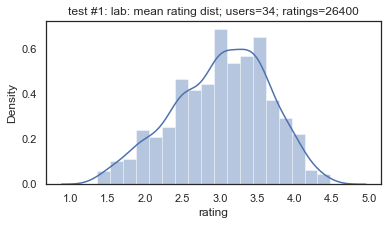

In [13]:
stats_lab1 = make_plots("lab_test_1/", "lab")

d(stats_lab1)
stats_lab1.to_csv("stats_lab_test_1.csv", index=False)

In [14]:
d(stats_click)
d(stats_lab1)

dlabclick = pd.merge(stats_click, stats_lab1, left_on="filename", right_on="filename", suffixes=("_click", "_lab"))

d(dlabclick)

,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0
...,...,...,...,...,...,...,...,...,...,...
1053,static/images/pixabay_first50k/medium/woman-35...,1.105013,0.517162,3.800000,20,1,1,5,7,6
1054,static/images/pixabay_first50k/medium/woman-38...,1.228321,0.592032,2.789474,19,3,5,6,3,2
1055,static/images/pixabay_first50k/medium/woman-53...,1.114741,0.573147,2.352941,17,4,6,5,1,1
1056,static/images/pixabay_first50k/medium/women-12...,1.063219,0.448958,3.000000,24,2,5,10,5,2


,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5
0,static/images/500px_cc0/medium/100327907_some_...,1.202451,0.533137,3.272727,22,1,6,5,6,4
1,static/images/500px_cc0/medium/1003502191_Flat...,1.295401,0.512443,3.296296,27,4,2,8,8,5
2,static/images/500px_cc0/medium/1011015162_Anem...,1.236033,0.479284,2.750000,28,4,9,9,2,4
3,static/images/500px_cc0/medium/1011015165_Anem...,1.276155,0.580899,2.142857,21,9,5,3,3,1
4,static/images/500px_cc0/medium/1011015217_Anem...,1.197068,0.505477,1.958333,24,13,2,7,1,1
...,...,...,...,...,...,...,...,...,...,...
1056,static/images/pixabay_first50k/medium/woman-35...,1.420726,0.573844,3.461538,26,3,4,6,4,9
1057,static/images/pixabay_first50k/medium/woman-38...,1.292097,0.511137,2.851852,27,4,9,4,7,3
1058,static/images/pixabay_first50k/medium/woman-53...,1.280625,0.528616,3.160000,25,3,4,9,4,5
1059,static/images/pixabay_first50k/medium/women-12...,1.174079,0.474221,3.461538,26,1,5,7,7,6


,filename,std_click,ci_click,mos_click,num_ratings_click,count_1_click,count_2_click,count_3_click,count_4_click,count_5_click,std_lab,ci_lab,mos_lab,num_ratings_lab,count_1_lab,count_2_lab,count_3_lab,count_4_lab,count_5_lab
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1,1.202451,0.533137,3.272727,22,1,6,5,6,4
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2,1.295401,0.512443,3.296296,27,4,2,8,8,5
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2,1.236033,0.479284,2.750000,28,4,9,9,2,4
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1,1.276155,0.580899,2.142857,21,9,5,3,3,1
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0,1.197068,0.505477,1.958333,24,13,2,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,static/images/pixabay_first50k/medium/woman-35...,1.105013,0.517162,3.800000,20,1,1,5,7,6,1.420726,0.573844,3.461538,26,3,4,6,4,9
1053,static/images/pixabay_first50k/medium/woman-38...,1.228321,0.592032,2.789474,19,3,5,6,3,2,1.292097,0.511137,2.851852,27,4,9,4,7,3
1054,static/images/pixabay_first50k/medium/woman-53...,1.114741,0.573147,2.352941,17,4,6,5,1,1,1.280625,0.528616,3.160000,25,3,4,9,4,5
1055,static/images/pixabay_first50k/medium/women-12...,1.063219,0.448958,3.000000,24,2,5,10,5,2,1.174079,0.474221,3.461538,26,1,5,7,7,6


In [62]:
metrics = []
from sklearn.metrics import mean_squared_error

[{'comparison': 'click vs. lab', 'pearson': 0.8447031005265305, 'kendall': 0.6343702225269505, 'spearman': 0.8228865602797093, 'RMSE': 0.3852138655781695}]


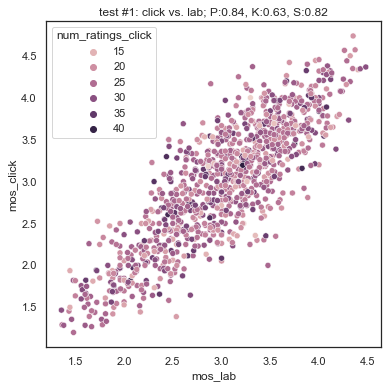

In [63]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")
ax = sns.scatterplot(x="mos_lab", y="mos_click", data=dlabclick, hue="num_ratings_click")

pearson = dlabclick[["mos_lab", "mos_click"]].corr(method="pearson")["mos_click"].values[0]
kendall = dlabclick[["mos_lab", "mos_click"]].corr(method="kendall")["mos_click"].values[0]
spearman = dlabclick[["mos_lab", "mos_click"]].corr(method="spearman")["mos_click"].values[0]

metrics.append(
    {
        "comparison": "click vs. lab",
        "pearson": pearson,
        "kendall": kendall,
        "spearman": spearman,
        "RMSE": np.sqrt(mean_squared_error(dlabclick["mos_lab"].values, dlabclick["mos_click"].values)) 
    }
)
print(metrics)

save_fig(
    ax, 
    f"test #1: click vs. lab; P:{pearson.round(2)}, K:{kendall.round(2)}, S:{spearman.round(2)}", 
    f"scatter_click_vs_lab.pdf"
)


In [19]:
dlabtuil = pd.merge(stats_tuil, stats_lab1, left_on="filename", right_on="filename", suffixes=("_tuil", "_lab"))

d(dlabtuil)

,filename,std_tuil,ci_tuil,mos_tuil,num_ratings_tuil,count_1_tuil,count_2_tuil,count_3_tuil,count_4_tuil,count_5_tuil,std_lab,ci_lab,mos_lab,num_ratings_lab,count_1_lab,count_2_lab,count_3_lab,count_4_lab,count_5_lab
0,static/images/500px_cc0/medium/100327907_some_...,0.832971,0.351733,2.208333,24,3,16,2,3,0,1.202451,0.533137,3.272727,22,1,6,5,6,4
1,static/images/500px_cc0/medium/1003502191_Flat...,1.325393,0.547095,3.440000,25,3,2,8,5,7,1.295401,0.512443,3.296296,27,4,2,8,8,5
2,static/images/500px_cc0/medium/1011015162_Anem...,1.268143,0.611225,2.947368,19,2,6,5,3,3,1.236033,0.479284,2.750000,28,4,9,9,2,4
3,static/images/500px_cc0/medium/1011015165_Anem...,0.746101,0.307975,1.840000,25,9,11,5,0,0,1.276155,0.580899,2.142857,21,9,5,3,3,1
4,static/images/500px_cc0/medium/1011015217_Anem...,1.288786,0.509827,2.259259,27,10,7,5,3,2,1.197068,0.505477,1.958333,24,13,2,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,static/images/pixabay_first50k/medium/woman-35...,1.416221,0.502170,3.454545,33,5,3,7,8,10,1.420726,0.573844,3.461538,26,3,4,6,4,9
1053,static/images/pixabay_first50k/medium/woman-38...,1.365479,0.519400,2.310345,29,12,6,2,8,1,1.292097,0.511137,2.851852,27,4,9,4,7,3
1054,static/images/pixabay_first50k/medium/woman-53...,1.046788,0.377407,2.468750,32,7,9,10,6,0,1.280625,0.528616,3.160000,25,3,4,9,4,5
1055,static/images/pixabay_first50k/medium/women-12...,1.227649,0.485642,3.259259,27,2,5,10,4,6,1.174079,0.474221,3.461538,26,1,5,7,7,6


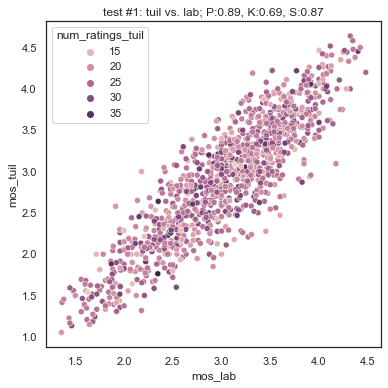

In [64]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")
ax = sns.scatterplot(x="mos_lab", y="mos_tuil", data=dlabtuil, hue="num_ratings_tuil")

pearson = dlabtuil[["mos_lab", "mos_tuil"]].corr(method="pearson")["mos_tuil"].values[0]
kendall = dlabtuil[["mos_lab", "mos_tuil"]].corr(method="kendall")["mos_tuil"].values[0]
spearman = dlabtuil[["mos_lab", "mos_tuil"]].corr(method="spearman")["mos_tuil"].values[0]

metrics.append(
    {
        "comparison": "tuil vs. lab",
        "pearson": pearson,
        "kendall": kendall,
        "spearman": spearman,
        "RMSE": np.sqrt(mean_squared_error(dlabtuil["mos_tuil"].values, dlabtuil["mos_lab"].values)) 
    }
)


save_fig(
    ax, 
    f"test #1: tuil vs. lab; P:{pearson.round(2)}, K:{kendall.round(2)}, S:{spearman.round(2)}", 
    f"scatter_tuil_vs_lab.pdf"
)

0.931179092860159 0.0 False


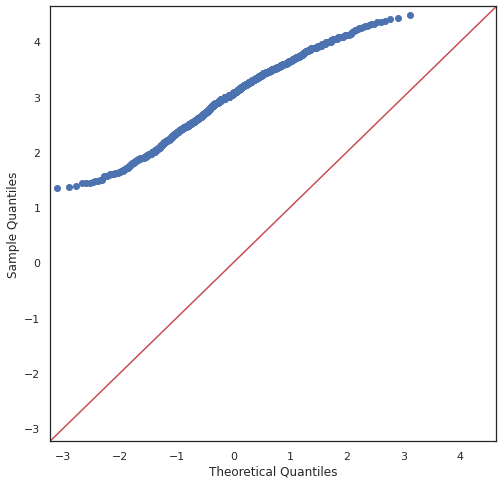

In [15]:
ks_statistic, p_value = kstest(stats_lab1["mos"], 'norm')
print(
    ks_statistic,
    p_value,
    p_value > 0.05
)


sm.qqplot(stats_lab1["mos"], line='45')
pylab.show()

In [22]:
dclicktuil = pd.merge(stats_click, stats_tuil, left_on="filename", right_on="filename", suffixes=("_click", "_tuil"))

d(dclicktuil)

,filename,std_click,ci_click,mos_click,num_ratings_click,count_1_click,count_2_click,count_3_click,count_4_click,count_5_click,std_tuil,ci_tuil,mos_tuil,num_ratings_tuil,count_1_tuil,count_2_tuil,count_3_tuil,count_4_tuil,count_5_tuil
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1,0.832971,0.351733,2.208333,24,3,16,2,3,0
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2,1.325393,0.547095,3.440000,25,3,2,8,5,7
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2,1.268143,0.611225,2.947368,19,2,6,5,3,3
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1,0.746101,0.307975,1.840000,25,9,11,5,0,0
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0,1.288786,0.509827,2.259259,27,10,7,5,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,static/images/pixabay_first50k/medium/woman-35...,1.105013,0.517162,3.800000,20,1,1,5,7,6,1.416221,0.502170,3.454545,33,5,3,7,8,10
1053,static/images/pixabay_first50k/medium/woman-38...,1.228321,0.592032,2.789474,19,3,5,6,3,2,1.365479,0.519400,2.310345,29,12,6,2,8,1
1054,static/images/pixabay_first50k/medium/woman-53...,1.114741,0.573147,2.352941,17,4,6,5,1,1,1.046788,0.377407,2.468750,32,7,9,10,6,0
1055,static/images/pixabay_first50k/medium/women-12...,1.063219,0.448958,3.000000,24,2,5,10,5,2,1.227649,0.485642,3.259259,27,2,5,10,4,6


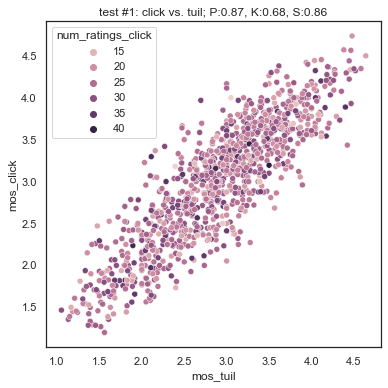

In [65]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")
ax = sns.scatterplot(x="mos_tuil", y="mos_click", data=dclicktuil, hue="num_ratings_click")

pearson = dclicktuil[["mos_click", "mos_tuil"]].corr(method="pearson")["mos_tuil"].values[0]
kendall = dclicktuil[["mos_click", "mos_tuil"]].corr(method="kendall")["mos_tuil"].values[0]
spearman = dclicktuil[["mos_click", "mos_tuil"]].corr(method="spearman")["mos_tuil"].values[0]



metrics.append(
    {
        "comparison": "click vs. tuil",
        "pearson": pearson,
        "kendall": kendall,
        "spearman": spearman,
        "RMSE": np.sqrt(mean_squared_error(dclicktuil["mos_click"].values, dclicktuil["mos_tuil"].values)) 
    }
)

save_fig(
    ax, 
    f"test #1: click vs. tuil; P:{pearson.round(2)}, K:{kendall.round(2)}, S:{spearman.round(2)}", 
    f"scatter_click_vs_tuil.pdf"
)

In [67]:
dmetrics = pd.DataFrame(metrics)
print(dmetrics.round(3).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
    comparison &  pearson &  kendall &  spearman &  RMSE \\
\midrule
 click vs. lab &    0.845 &    0.634 &     0.823 & 0.385 \\
  tuil vs. lab &    0.886 &    0.689 &     0.868 & 0.357 \\
click vs. tuil &    0.872 &    0.677 &     0.862 & 0.379 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1121491/2207160614.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dmetrics.round(3).to_latex(index=False))


In [25]:
stats_click["type"] = "click"
d(stats_click)
stats_tuil["type"] = "tuil"
d(stats_tuil)
stats_lab1["type"] = "lab"
d(stats_lab1)

,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,type
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1,click
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2,click
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2,click
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1,click
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0,click
...,...,...,...,...,...,...,...,...,...,...,...
1053,static/images/pixabay_first50k/medium/woman-35...,1.105013,0.517162,3.800000,20,1,1,5,7,6,click
1054,static/images/pixabay_first50k/medium/woman-38...,1.228321,0.592032,2.789474,19,3,5,6,3,2,click
1055,static/images/pixabay_first50k/medium/woman-53...,1.114741,0.573147,2.352941,17,4,6,5,1,1,click
1056,static/images/pixabay_first50k/medium/women-12...,1.063219,0.448958,3.000000,24,2,5,10,5,2,click


,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,type
0,static/images/500px_cc0/medium/100327907_some_...,0.832971,0.351733,2.208333,24,3,16,2,3,0,tuil
1,static/images/500px_cc0/medium/1003502191_Flat...,1.325393,0.547095,3.440000,25,3,2,8,5,7,tuil
2,static/images/500px_cc0/medium/1011015162_Anem...,1.268143,0.611225,2.947368,19,2,6,5,3,3,tuil
3,static/images/500px_cc0/medium/1011015165_Anem...,0.746101,0.307975,1.840000,25,9,11,5,0,0,tuil
4,static/images/500px_cc0/medium/1011015217_Anem...,1.288786,0.509827,2.259259,27,10,7,5,3,2,tuil
...,...,...,...,...,...,...,...,...,...,...,...
1052,static/images/pixabay_first50k/medium/woman-35...,1.416221,0.502170,3.454545,33,5,3,7,8,10,tuil
1053,static/images/pixabay_first50k/medium/woman-38...,1.365479,0.519400,2.310345,29,12,6,2,8,1,tuil
1054,static/images/pixabay_first50k/medium/woman-53...,1.046788,0.377407,2.468750,32,7,9,10,6,0,tuil
1055,static/images/pixabay_first50k/medium/women-12...,1.227649,0.485642,3.259259,27,2,5,10,4,6,tuil


,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,type
0,static/images/500px_cc0/medium/100327907_some_...,1.202451,0.533137,3.272727,22,1,6,5,6,4,lab
1,static/images/500px_cc0/medium/1003502191_Flat...,1.295401,0.512443,3.296296,27,4,2,8,8,5,lab
2,static/images/500px_cc0/medium/1011015162_Anem...,1.236033,0.479284,2.750000,28,4,9,9,2,4,lab
3,static/images/500px_cc0/medium/1011015165_Anem...,1.276155,0.580899,2.142857,21,9,5,3,3,1,lab
4,static/images/500px_cc0/medium/1011015217_Anem...,1.197068,0.505477,1.958333,24,13,2,7,1,1,lab
...,...,...,...,...,...,...,...,...,...,...,...
1056,static/images/pixabay_first50k/medium/woman-35...,1.420726,0.573844,3.461538,26,3,4,6,4,9,lab
1057,static/images/pixabay_first50k/medium/woman-38...,1.292097,0.511137,2.851852,27,4,9,4,7,3,lab
1058,static/images/pixabay_first50k/medium/woman-53...,1.280625,0.528616,3.160000,25,3,4,9,4,5,lab
1059,static/images/pixabay_first50k/medium/women-12...,1.174079,0.474221,3.461538,26,1,5,7,7,6,lab


In [27]:
df_all = pd.concat([stats_click, stats_tuil, stats_lab1], ignore_index=True)
d(df_all)

,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,type
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1,click
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2,click
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2,click
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1,click
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0,click
...,...,...,...,...,...,...,...,...,...,...,...
3171,static/images/pixabay_first50k/medium/woman-35...,1.420726,0.573844,3.461538,26,3,4,6,4,9,lab
3172,static/images/pixabay_first50k/medium/woman-38...,1.292097,0.511137,2.851852,27,4,9,4,7,3,lab
3173,static/images/pixabay_first50k/medium/woman-53...,1.280625,0.528616,3.160000,25,3,4,9,4,5,lab
3174,static/images/pixabay_first50k/medium/women-12...,1.174079,0.474221,3.461538,26,1,5,7,7,6,lab


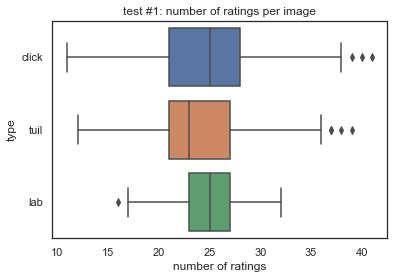

In [36]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("white")
ax = sns.boxplot(x="num_ratings", y="type", data=df_all)
ax.set_xlabel("number of ratings")

save_fig(
    ax, 
    "test #1: number of ratings per image", 
    "number_of_ratings_all.pdf"
)



In [101]:
for i, g in df_all.groupby(by="type"):
    print(i, np.median(g["num_ratings"]), g["num_ratings"].min(), g["num_ratings"].max())


click 25.0 11 41
lab 25.0 16 32
tuil 23.0 12 39


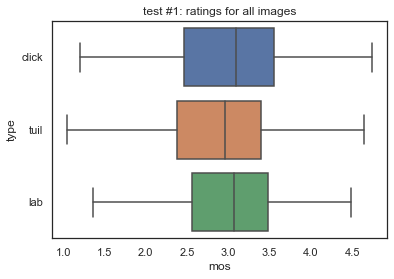

In [46]:
sns.set(rc={'figure.figsize':(6,4)})
sns.set_style("white")
ax = sns.boxplot(x="mos", y="type", data=df_all)

save_fig(
    ax, 
    "test #1: ratings for all images", 
    "ratings_all.pdf"
)


In [51]:
def sos_plot(df, title=""):
    assert("mos" in df.columns)
    assert("std" in df.columns)
    
    sns.set(rc={'figure.figsize':(6,4)})
    sns.set_style("white")

    ax = sns.scatterplot(x="mos", y="std", data=df)
    x_data = df["mos"].values
    y_data = df["std"].replace(np.NaN, 0).values

    from scipy.optimize import curve_fit

    def fitting_function(x, a):
        return (x - 1) * (x - 5) * (-a)

    popt, pcov = curve_fit(fitting_function, x_data, y_data) 


    x = np.linspace(1, 5, 100)
    ax.plot(x, fitting_function(x, *popt), 'g--')
    ax.set_title(title + f" estimated a: {popt[0].round(3)}")
    return ax



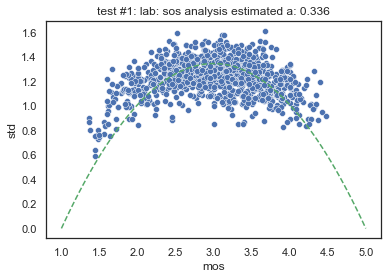

In [60]:
save_fig(
    sos_plot(
        df_all[df_all["type"] == "lab"], 
        "test #1: lab: sos analysis"
    ), 
    title=None, 
    pdfname="test_1_lab_sos.pdf"
)

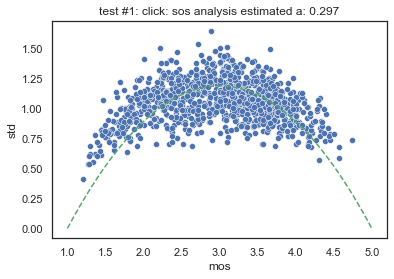

In [59]:
save_fig(
    sos_plot(
        df_all[df_all["type"] == "click"], 
        "test #1: click: sos analysis"
    ), 
    title=None, 
    pdfname="test_1_click_sos.pdf"
)

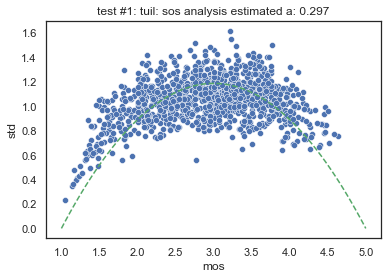

In [58]:
save_fig(
    sos_plot(
        df_all[df_all["type"] == "tuil"], 
        "test #1: tuil: sos analysis"
    ), 
    title=None, 
    pdfname="test_1_tuil_sos.pdf"
)

In [72]:
df_all.to_csv("all_test.csv", index=False)
d(df_all)

,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,type
0,static/images/500px_cc0/medium/100327907_some_...,1.092398,0.450920,2.880000,25,4,3,11,6,1,click
1,static/images/500px_cc0/medium/1003502191_Flat...,1.099766,0.475575,2.869565,23,2,7,8,4,2,click
2,static/images/500px_cc0/medium/1011015162_Anem...,0.978093,0.403737,2.960000,25,1,7,11,4,2,click
3,static/images/500px_cc0/medium/1011015165_Anem...,1.144703,0.427439,2.000000,30,14,6,7,2,1,click
4,static/images/500px_cc0/medium/1011015217_Anem...,0.888523,0.415842,2.500000,20,2,9,6,3,0,click
...,...,...,...,...,...,...,...,...,...,...,...
3171,static/images/pixabay_first50k/medium/woman-35...,1.420726,0.573844,3.461538,26,3,4,6,4,9,lab
3172,static/images/pixabay_first50k/medium/woman-38...,1.292097,0.511137,2.851852,27,4,9,4,7,3,lab
3173,static/images/pixabay_first50k/medium/woman-53...,1.280625,0.528616,3.160000,25,3,4,9,4,5,lab
3174,static/images/pixabay_first50k/medium/women-12...,1.174079,0.474221,3.461538,26,1,5,7,7,6,lab


In [73]:
dava = pd.read_csv("../images/ava/ratings.csv")
dava["image"] = dava["file"].apply(lambda x: "static/images/ava/medium/" + os.path.basename(x))
d(dava)

,Index,Image_ID,rating_counts,r_1,r_2,r_3,r_4,r_5,r_6,r_7,...,Semanting_Tag_ID,Challenge_ID,mos,num_raters,file,id,norm_mos,10i_mos,5i_mos,image
0,8554,43085,39,45,50,59,26,10,6,1,...,0,150,2.634518,197.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,43085,0.126223,1,0,static/images/ava/medium/43085.jpg
1,129388,776337,8,19,36,65,55,12,2,2,...,0,1010,3.099476,191.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,776337,0.199066,1,0,static/images/ava/medium/776337.jpg
2,23391,638912,39,24,37,39,40,13,1,1,...,0,807,2.961538,156.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,638912,0.177456,1,0,static/images/ava/medium/638912.jpg
3,163206,74764,34,60,63,70,55,12,7,3,...,0,215,2.805861,273.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,74764,0.153067,1,0,static/images/ava/medium/74764.jpg
4,198624,335761,54,48,50,50,35,20,3,1,...,17,496,2.858491,212.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,335761,0.161312,1,0,static/images/ava/medium/335761.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,217725,780373,0,1,1,1,18,34,40,53,...,29,1017,6.976378,254.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,780373,0.806442,8,4,static/images/ava/medium/780373.jpg
197,140616,51662,1,0,2,5,11,26,26,24,...,28,167,6.935897,156.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,51662,0.800100,8,4,static/images/ava/medium/51662.jpg
198,1292,267110,1,0,1,5,10,26,58,85,...,14,419,7.380319,376.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,267110,0.869726,8,4,static/images/ava/medium/267110.jpg
199,227389,727495,0,0,1,2,10,24,35,50,...,21,928,7.178082,219.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,727495,0.838042,8,4,static/images/ava/medium/727495.jpg


In [75]:
df_all_ava = pd.merge(df_all, dava, left_on="filename", right_on="image", suffixes=("", "_ava"))
d(df_all_ava)

,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,...,Semanting_Tag_ID,Challenge_ID,mos_ava,num_raters,file,id,norm_mos,10i_mos,5i_mos,image
0,static/images/ava/medium/10003.jpg,0.937180,0.363401,2.714286,28,2,10,11,4,1,...,22,50,6.018349,109.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,10003,0.656352,6,3,static/images/ava/medium/10003.jpg
1,static/images/ava/medium/10003.jpg,0.957427,0.395206,3.200000,25,1,4,11,7,2,...,22,50,6.018349,109.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,10003,0.656352,6,3,static/images/ava/medium/10003.jpg
2,static/images/ava/medium/10003.jpg,1.347151,0.532915,3.259259,27,4,3,8,6,6,...,22,50,6.018349,109.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,10003,0.656352,6,3,static/images/ava/medium/10003.jpg
3,static/images/ava/medium/103189.jpg,1.080935,0.505893,3.300000,20,2,1,8,7,2,...,35,254,5.532530,415.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,103189,0.580241,5,2,static/images/ava/medium/103189.jpg
4,static/images/ava/medium/103189.jpg,1.242521,0.598876,3.105263,19,1,6,6,2,4,...,35,254,5.532530,415.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,103189,0.580241,5,2,static/images/ava/medium/103189.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,static/images/ava/medium/9538.jpg,1.069867,0.432129,3.230769,26,0,7,11,3,5,...,0,24,7.309735,113.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,9538,0.858668,8,4,static/images/ava/medium/9538.jpg
554,static/images/ava/medium/9538.jpg,1.020621,0.430970,2.791667,24,3,6,8,7,0,...,0,24,7.309735,113.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,9538,0.858668,8,4,static/images/ava/medium/9538.jpg
555,static/images/ava/medium/958117.jpg,0.571241,0.267349,4.300000,20,0,0,1,12,7,...,0,1408,7.173184,179.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,958117,0.837275,8,4,static/images/ava/medium/958117.jpg
556,static/images/ava/medium/958117.jpg,0.961569,0.388386,4.269231,26,0,2,3,7,14,...,0,1408,7.173184,179.0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,958117,0.837275,8,4,static/images/ava/medium/958117.jpg


In [90]:
values = []

for ty in ["lab", "click", "tuil"]:
    p = df_all_ava[df_all_ava["type"] == ty][["mos", "mos_ava"]].corr(method="pearson")["mos"][1]
    k = df_all_ava[df_all_ava["type"] == ty][["mos", "mos_ava"]].corr(method="kendall")["mos"][1]
    s = df_all_ava[df_all_ava["type"] == ty][["mos", "mos_ava"]].corr(method="spearman")["mos"][1]
    
    values.append(
        {
            "subset": "ava",
            "type": ty,
            "pearson": p,
            "kendall": k,
            "spearman": s
        }
    )

p = df_all_ava[["mos", "mos_ava"]].corr(method="pearson")["mos"][1]
k = df_all_ava[["mos", "mos_ava"]].corr(method="kendall")["mos"][1]
s = df_all_ava[["mos", "mos_ava"]].corr(method="spearman")["mos"][1]

df_ava_metrics = pd.DataFrame(values).sort_values(by="pearson", ascending=False)
print(df_ava_metrics.round(3).to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
subset &  type &  pearson &  kendall &  spearman \\
\midrule
   ava &  tuil &    0.811 &    0.610 &     0.812 \\
   ava & click &    0.777 &    0.577 &     0.772 \\
   ava &   lab &    0.756 &    0.540 &     0.746 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1121491/1485572483.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_ava_metrics.round(3).to_latex(index=False))


In [94]:
daadb = pd.read_csv("../images/aadb/ratings.csv")
d(daadb)
daadb["mos_aadb"] = daadb["mean"]
daadb["image"] = daadb["image"].apply(lambda x: "static/images/aadb/medium/" + os.path.basename(x))
d(daadb)

,image,url,count,mean,max,min,norm_mean,5i_mean
0,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,https://farm1.staticflickr.com/336/20161142751...,5,0.2,1,0,0.04,0
1,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,https://farm1.staticflickr.com/300/20203544192...,5,0.8,4,0,0.16,0
2,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,https://farm1.staticflickr.com/284/19899946970...,5,0.6,3,0,0.12,0
3,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,https://farm1.staticflickr.com/316/20089403335...,5,0.6,3,0,0.12,0
4,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,https://farm1.staticflickr.com/263/19568286334...,5,0.0,0,0,0.00,0
...,...,...,...,...,...,...,...,...
207,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,https://farm1.staticflickr.com/286/19998340455...,5,5.0,5,5,1.00,5
208,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,https://farm1.staticflickr.com/263/20317768422...,5,5.0,5,5,1.00,5
209,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,https://farm1.staticflickr.com/297/19951672000...,5,5.0,5,5,1.00,5
210,/home/sgoering/shares/avt_prio2/avt-work_sftp/...,https://farm1.staticflickr.com/399/19971092260...,5,5.0,5,5,1.00,5


,image,url,count,mean,max,min,norm_mean,5i_mean,mos_aadb
0,static/images/aadb/medium/farm1_336_2016114275...,https://farm1.staticflickr.com/336/20161142751...,5,0.2,1,0,0.04,0,0.2
1,static/images/aadb/medium/farm1_300_2020354419...,https://farm1.staticflickr.com/300/20203544192...,5,0.8,4,0,0.16,0,0.8
2,static/images/aadb/medium/farm1_284_1989994697...,https://farm1.staticflickr.com/284/19899946970...,5,0.6,3,0,0.12,0,0.6
3,static/images/aadb/medium/farm1_316_2008940333...,https://farm1.staticflickr.com/316/20089403335...,5,0.6,3,0,0.12,0,0.6
4,static/images/aadb/medium/farm1_263_1956828633...,https://farm1.staticflickr.com/263/19568286334...,5,0.0,0,0,0.00,0,0.0
...,...,...,...,...,...,...,...,...,...
207,static/images/aadb/medium/farm1_286_1999834045...,https://farm1.staticflickr.com/286/19998340455...,5,5.0,5,5,1.00,5,5.0
208,static/images/aadb/medium/farm1_263_2031776842...,https://farm1.staticflickr.com/263/20317768422...,5,5.0,5,5,1.00,5,5.0
209,static/images/aadb/medium/farm1_297_1995167200...,https://farm1.staticflickr.com/297/19951672000...,5,5.0,5,5,1.00,5,5.0
210,static/images/aadb/medium/farm1_399_1997109226...,https://farm1.staticflickr.com/399/19971092260...,5,5.0,5,5,1.00,5,5.0


In [95]:
df_all_aadb = pd.merge(df_all, daadb, left_on="filename", right_on="image", suffixes=("", "_aadb"))
d(df_all_aadb)

,filename,std,ci,mos,num_ratings,count_1,count_2,count_3,count_4,count_5,type,image,url,count,mean,max,min,norm_mean,5i_mean,mos_aadb
0,static/images/aadb/medium/farm1_256_2010840835...,0.769670,0.325003,2.375000,24,3,10,10,1,0,click,static/images/aadb/medium/farm1_256_2010840835...,https://farm1.staticflickr.com/256/20108408355...,5,3.6,4,3,0.72,3,3.6
1,static/images/aadb/medium/farm1_256_2010840835...,1.021437,0.421628,2.720000,25,2,10,7,5,1,tuil,static/images/aadb/medium/farm1_256_2010840835...,https://farm1.staticflickr.com/256/20108408355...,5,3.6,4,3,0.72,3,3.6
2,static/images/aadb/medium/farm1_256_2010840835...,1.403928,0.592827,2.833333,24,5,5,8,1,5,lab,static/images/aadb/medium/farm1_256_2010840835...,https://farm1.staticflickr.com/256/20108408355...,5,3.6,4,3,0.72,3,3.6
3,static/images/aadb/medium/farm1_257_2014530889...,1.092035,0.393721,1.968750,32,13,11,6,0,2,click,static/images/aadb/medium/farm1_257_2014530889...,https://farm1.staticflickr.com/257/20145308899...,5,2.4,3,2,0.48,2,2.4
4,static/images/aadb/medium/farm1_257_2014530889...,1.174286,0.549583,2.300000,20,6,6,5,2,1,tuil,static/images/aadb/medium/farm1_257_2014530889...,https://farm1.staticflickr.com/257/20145308899...,5,2.4,3,2,0.48,2,2.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,static/images/aadb/medium/farm4_3826_200029059...,0.816497,0.452161,2.333333,15,2,7,5,1,0,tuil,static/images/aadb/medium/farm4_3826_200029059...,https://farm4.staticflickr.com/3826/2000290592...,5,0.8,4,0,0.16,0,0.8
545,static/images/aadb/medium/farm4_3826_200029059...,1.230133,0.476996,2.571429,28,7,6,9,4,2,lab,static/images/aadb/medium/farm4_3826_200029059...,https://farm4.staticflickr.com/3826/2000290592...,5,0.8,4,0,0.16,0,0.8
546,static/images/aadb/medium/farm4_3834_202015536...,0.943242,0.484970,3.470588,17,0,3,5,7,2,click,static/images/aadb/medium/farm4_3834_202015536...,https://farm4.staticflickr.com/3834/2020155367...,5,5.0,5,5,1.00,5,5.0
547,static/images/aadb/medium/farm4_3834_202015536...,0.816497,0.344776,3.333333,24,0,3,12,7,2,tuil,static/images/aadb/medium/farm4_3834_202015536...,https://farm4.staticflickr.com/3834/2020155367...,5,5.0,5,5,1.00,5,5.0


In [96]:
values = []

for ty in ["lab", "click", "tuil"]:
    p = df_all_aadb[df_all_aadb["type"] == ty][["mos", "mos_aadb"]].corr(method="pearson")["mos"][1]
    k = df_all_aadb[df_all_aadb["type"] == ty][["mos", "mos_aadb"]].corr(method="kendall")["mos"][1]
    s = df_all_aadb[df_all_aadb["type"] == ty][["mos", "mos_aadb"]].corr(method="spearman")["mos"][1]
    
    values.append(
        {
            "subset": "aadb",
            "type": ty,
            "pearson": p,
            "kendall": k,
            "spearman": s
        }
    )


df_aadb_metrics = pd.DataFrame(values).sort_values(by="pearson", ascending=False)
print(df_aadb_metrics.round(3).to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
subset &  type &  pearson &  kendall &  spearman \\
\midrule
  aadb &  tuil &    0.635 &    0.490 &     0.670 \\
  aadb &   lab &    0.615 &    0.477 &     0.650 \\
  aadb & click &    0.614 &    0.477 &     0.651 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1121491/3285139290.py:20: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_aadb_metrics.round(3).to_latex(index=False))


In [98]:
df_cmp_metrics = pd.concat([df_ava_metrics, df_aadb_metrics], ignore_index=True)

print(df_cmp_metrics.round(3).to_latex(index=False))


\begin{tabular}{llrrr}
\toprule
subset &  type &  pearson &  kendall &  spearman \\
\midrule
   ava &  tuil &    0.811 &    0.610 &     0.812 \\
   ava & click &    0.777 &    0.577 &     0.772 \\
   ava &   lab &    0.756 &    0.540 &     0.746 \\
  aadb &  tuil &    0.635 &    0.490 &     0.670 \\
  aadb &   lab &    0.615 &    0.477 &     0.650 \\
  aadb & click &    0.614 &    0.477 &     0.651 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1121491/4242575422.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_cmp_metrics.round(3).to_latex(index=False))
